In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!pip install -q tensorflow
!pip install -q mediapipe==0.10.0
# !wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 35.2 MB/s eta 0:00:00


In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.vision.core.vision_task_running_mode import VisionTaskRunningMode
import cv2
from google.colab.patches import cv2_imshow
import os

input_folder = '/content/drive/MyDrive/Colab Notebooks/TESI/dataset/dataset_img_2'

base_options = python.BaseOptions(model_asset_path='/content/drive/MyDrive/Colab Notebooks/TESI/pose_landmarker.task')

options = vision.PoseLandmarkerOptions(
    base_options = base_options,
    running_mode = VisionTaskRunningMode.IMAGE,
    num_poses = 1,
    min_pose_detection_confidence = 0.5,
    min_pose_presence_confidence = 0.5,
    min_tracking_confidence = 0.5,
    output_segmentation_masks = False
)

detector = vision.PoseLandmarker.create_from_options(options)

num_keypoints = 33 # usati per identificare l'elemento
num_classes = 4
num_coordinates = 3

significant_indexes = [11,12,13,14,15,16,23,24,25,26,27,28,31,32]

labels = ['back_lever', 'planche', 'front_lever', 'handstand']

'''
7 - left ear
8 - right ear

11 - left shoulder
12 - right shoulder
13 - left elbow
14 - right elbow
15 - left wrist
16 - right wrist
23 - left hip
24 - right hip
25 - left knee
26 - right knee
27 - left ankle
28 - right ankle
31 - left foot index
32 - right foot index
'''

'''
0 - ear
1 - shoulder
2 - elbow
3 - wrist
4 - hip
5 - knee
6 - ankle
7 - foot index
'''

'\n0 - ear\n1 - shoulder\n2 - elbow\n3 - wrist\n4 - hip\n5 - knee\n6 - ankle\n7 - foot index\n'

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/TESI/lstm_last.h5')

In [ ]:
from google.colab import files
import numpy as np
from mediapipe.framework.formats import landmark_pb2

def upload_file():
  uploaded = files.upload()
  filenames = []

  for filename in uploaded:
    content = uploaded[filename]
    with open(filename, 'wb') as f:
      f.write(content)

    if len(uploaded.keys()):
      IMAGE_FILE = next(iter(uploaded))
      filenames.append(IMAGE_FILE)
      print('Uploaded file:', IMAGE_FILE)
  return filenames[0]

def extract_keypoints_2d(pose_landmarks):
  landmarks = []
  for i, pl in enumerate(pose_landmarks):
    coordinates = [pose_landmarks[i].x, pose_landmarks[i].y]
    landmarks.append(coordinates)
  landmarks = np.array(landmarks).reshape(1,num_keypoints,num_coordinates)
  return landmarks

def extract_keypoints_3d(pose_landmarks):
  landmarks = []
  for i, pl in enumerate(pose_landmarks):
    coordinates = [pose_landmarks[i].x, pose_landmarks[i].y, pose_landmarks[i].z ]
    landmarks.append(coordinates)
  landmarks = np.array(landmarks).reshape(1, num_keypoints, num_coordinates, 1)
  return landmarks

def draw_landmarks(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  pose_landmarks = pose_landmarks_list[0]

  pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
  pose_landmarks_proto.landmark.extend([
    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
  ])
  solutions.drawing_utils.draw_landmarks(
    annotated_image,
    pose_landmarks_proto,
    solutions.pose.POSE_CONNECTIONS,
    solutions.drawing_styles.get_default_pose_landmarks_style()
  )
  return annotated_image


Saving Screenshot_20240430_113701_Instagram.jpg to Screenshot_20240430_113701_Instagram (2).jpg
Uploaded file: Screenshot_20240430_113701_Instagram (2).jpg
1/1 [==============================] - 0s 38ms/step

Predicted Label: handstand



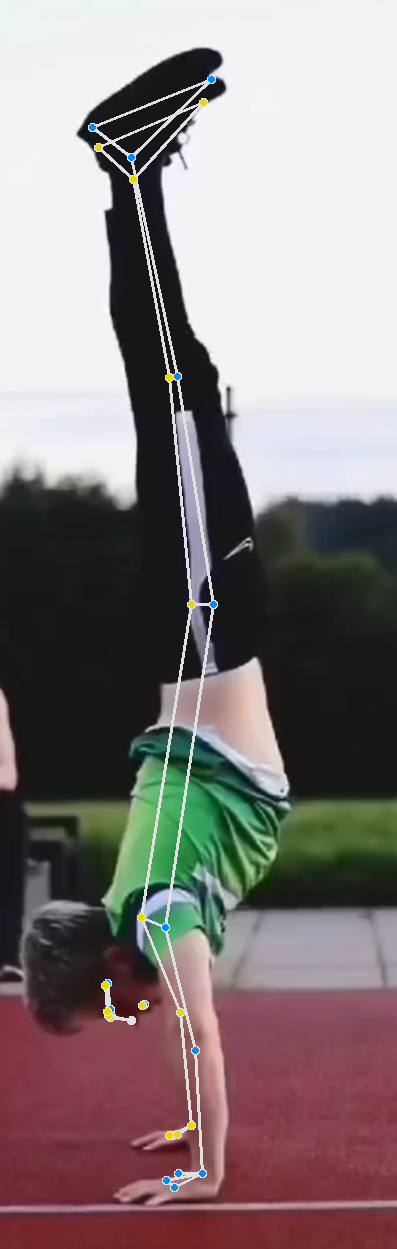

In [ ]:
from mediapipe import solutions

filename = upload_file()

image = mp.Image.create_from_file(filename)
detection_result = detector.detect(image)
pose_landmarks = detection_result.pose_landmarks[0]

landmarks = extract_keypoints_3d(pose_landmarks)

prediction = model.predict(landmarks)
predicted_class = np.argmax(prediction)

#print(prediction, predicted_class)

print(f"\nPredicted Label: {labels[predicted_class]}\n")

annotated_image = draw_landmarks(image.numpy_view(), detection_result)

cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

397


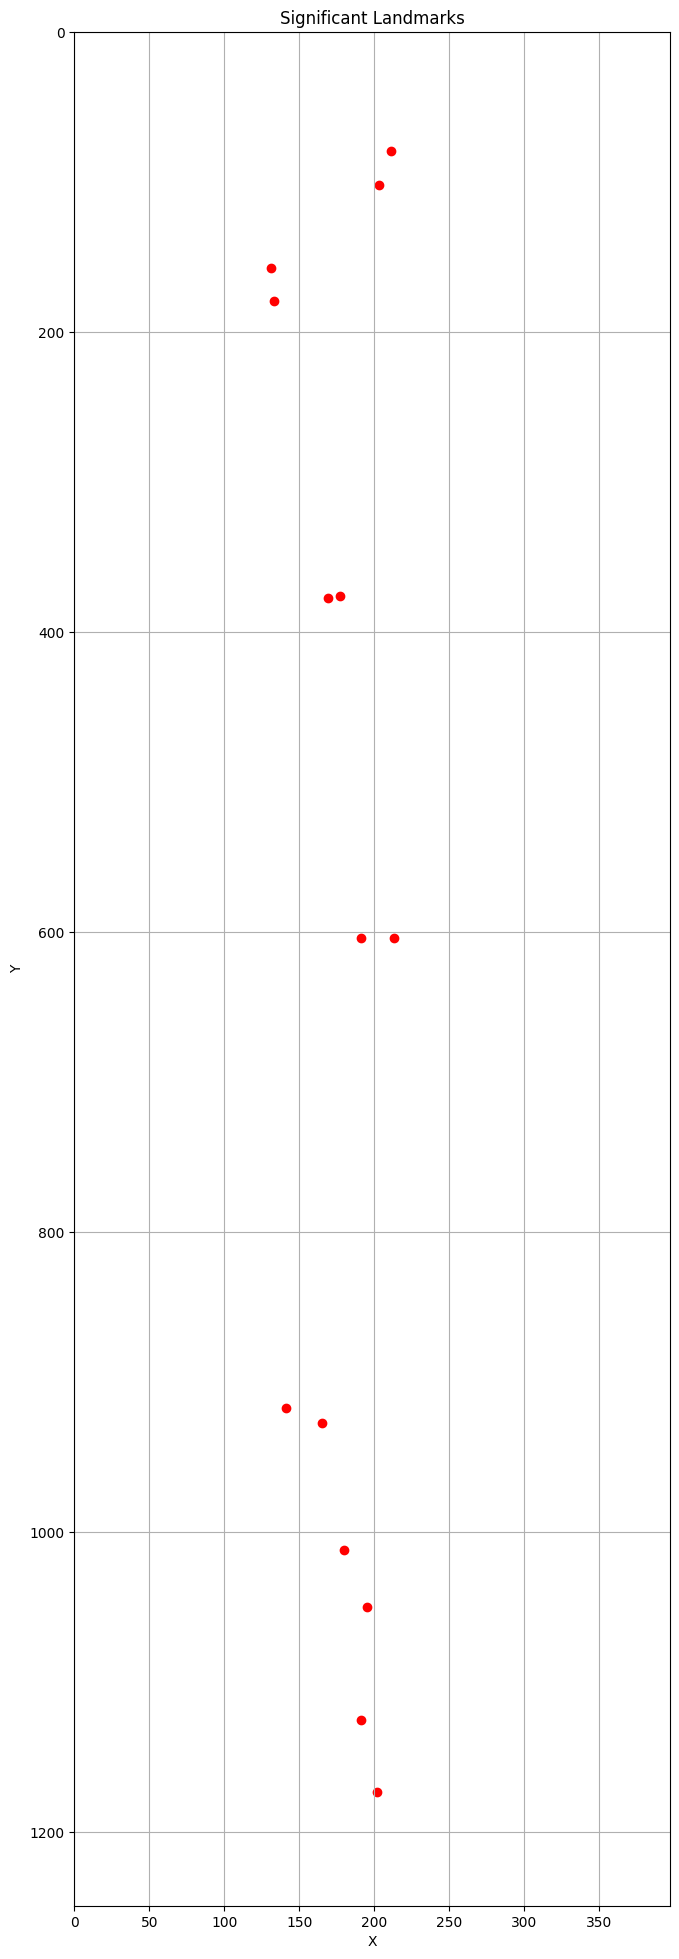

In [ ]:
from matplotlib import pyplot as plt

def plot_landmarks(indexes):
  pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
  pose_landmarks_proto.landmark.extend([
    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
  ])
  image_rows, image_cols, _ = image.numpy_view().shape
  coordinates = {}
  for idx, landmark in enumerate(pose_landmarks_proto.landmark):
    landmark_px = solutions.drawing_utils._normalized_to_pixel_coordinates(
        landmark.x,
        landmark.y,
        image_cols,
        image_rows
    )
    if landmark_px:
      # print(len(landmark_px))
      coordinates[idx] = landmark_px

  x = [coordinates[idx][0] for idx in indexes if idx in coordinates]
  y = [coordinates[idx][1] for idx in indexes if idx in coordinates]
  z = [detection_result.pose_landmarks[0][idx].z for idx in indexes]

  fig, ax = plt.subplots(figsize=(image_cols / 200, image_rows / 200))
  plt.scatter(x, y, color='red')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Significant Landmarks')
  plt.grid(True)
  plt.xlim(0, image_cols)
  plt.ylim(image_rows, 0)
  # plt.tight_layout()
  print(image_cols)
  if(image_cols < 800):
    plt.subplots_adjust(left=0.5, bottom=0.5, right=2,top=2)
  if(image_cols < 400):
    plt.subplots_adjust(left=1, bottom=1, right=4,top=4)


  plt.show()

  return x, y, z

x_significant, y_significant, z_significant = plot_landmarks(significant_indexes)

# TODO: stampare z delle caviglie

left hip angle:  162.57469101203918
right hip angle:  165.38839582952215


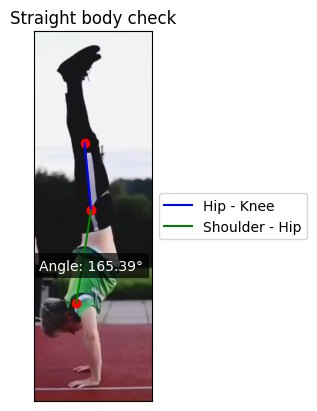

 --> Corpo allineato

left body slope angle:  1.6149235070247139
right body slope angle:  1.5816360106262752


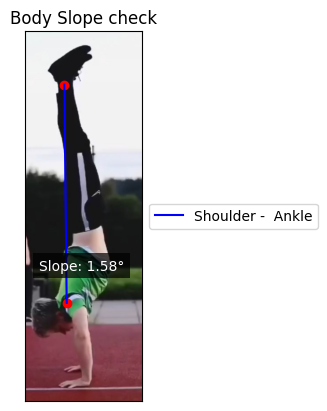

 --> Corpo parallelo

left arm angle 169.55026093658714
right arm angle 163.24050687033446


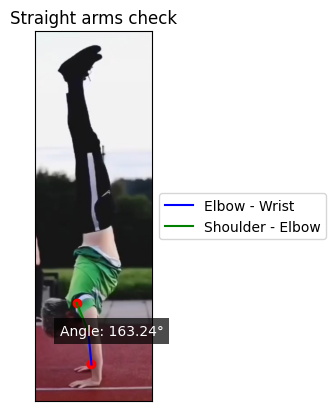

 !!! Errore: braccia non tese


left straight feet deg 122.41249086060697
right straight feet deg 127.42146452514021


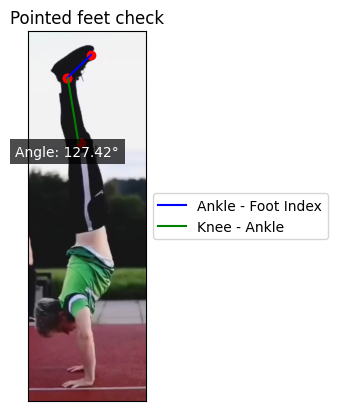

 !!! Errore: punte dei piedi non tirate




In [ ]:
# - punte dei piedi tirate: angolo tra [punta, caviglia] e [caviglia, ginocchio] > 145                                                         :::: FATTO
# - linea [spalle, bacino] e [bacino, ginocchia] AND [bacino, ginocchia] e [ginocchia, caviglia] AND [spalla, caviglia] parallela ad y=0       :::: FATTO
# - braccia tese: angolo tra [polso, gomito] e [gomito, spalla] >= 180                                                                         :::: FATTO

'''
0 - ear
1 - shoulder
2 - elbow
3 - wrist
4 - hip
5 - knee
6 - ankle
7 - foot index
'''
'''
0 - left shoulder
1 - right shoulder
2 - left elbow
3 - right elbow
4 - left wrist
5 - right wrist
6 - left hip
7 - right hip
8 - left knee
9 - right knee
10 - left ankle
11 - right ankle
12 - left foot index
13 - right foot index
'''

from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

def straight_body_v2(x, y):

  # left check

  # hip - knee
  x0_left = [x[6], x[8]]
  y0_left = [1 - y[6], 1 - y[8]]

  f0_left = interp1d(x0_left, y0_left, kind='linear')

  # shoulder - hip
  x1_left = [x[0], x[6]]
  y1_left = [1 - y[0], 1 - y[6]]

  f1_left = interp1d(x1_left, y1_left, kind='linear')

  v0_left = np.array([x0_left[1] - x0_left[0], y0_left[1] - y0_left[0]])
  v1_left = np.array([x1_left[0] - x1_left[1], y1_left[0] - y1_left[1]])

  angle_rad_left = np.arctan2(np.linalg.det([v0_left,v1_left]),np.dot(v0_left,v1_left))
  angle_deg_left = np.abs(np.degrees(angle_rad_left))

  print("left hip angle: ", angle_deg_left)

  # right check

  # hip - knee
  x0_right = [x[7], x[9]]
  y0_right = [1 - y[7], 1 - y[9]]

  f0_right = interp1d(x0_right, y0_right, kind='linear')

  # shoulder - hip
  x1_right = [x[1], x[7]]
  y1_right = [1 - y[1], 1 - y[7]]

  f1_right = interp1d(x1_right, y1_right, kind='linear')

  v0_right = np.array([x0_right[1] - x0_right[0], y0_right[1] - y0_right[0]])
  v1_right = np.array([x1_right[0] - x1_right[1], y1_right[0] - y1_right[1]])

  angle_rad_right = np.arctan2(np.linalg.det([v0_right, v1_right]),np.dot(v0_right, v1_right))
  angle_deg_right = np.abs(np.degrees(angle_rad_right))

  print("right hip angle: ", angle_deg_right)

  # ONLY FOR DEMONSTRATION, showing the camera best side, right in this case

  fig, ax = plt.subplots()
  ax.set_aspect('equal', adjustable='box')
  plt.title("Straight body check")
  plt.imshow(image.numpy_view())


  f0_right_image = interp1d(x0_right, (1 - np.array(y0_right)), kind='linear')
  f1_right_image = interp1d(x1_right, (1 - np.array(y1_right)), kind='linear')

  plt.plot(x0_right, f0_right_image(x0_right), label='Hip - Knee', color='blue')
  plt.plot(x1_right, f1_right_image(x1_right), label='Shoulder - Hip', color='green')

  plt.scatter(x0_right, (1 - np.array(y0_right)), color='red')
  plt.scatter(x1_right, (1 - np.array(y1_right)), color='red')

  image_rows, image_cols, _ = image.numpy_view().shape

  plt.text(x[7], y[7] + (image_rows*15)/100, f'Angle: {angle_deg_right:.2f}°', ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.7, edgecolor='none'))

  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  ################################################################################

  if(angle_deg_left >= 150 and angle_deg_right >= 150):
    return True
  else:
    return False

def parallel_body(x, y):

  # left check

  # shoulder - ankle
  x0_left = [x[0], x[10]]
  y0_left = [1 - y[0], 1 - y[10]]

  f0_left = interp1d(x0_left, y0_left, kind='linear')

  angle_deg_left = np.arctan2(y0_left[1] - y0_left[0], x0_left[1] - x0_left[0])

  print("left body slope angle: ", angle_deg_left)

  # right check

  # shoulder - ankle
  x0_right = [x[1], x[11]]
  y0_right = [1 - y[1], 1 - y[11]]

  f0_right = interp1d(x0_right, y0_right, kind='linear')

  angle_deg_right = np.arctan2(y0_right[1] - y0_right[0], x0_right[1] - x0_right[0])

  print("right body slope angle: ", angle_deg_right)

  # ONLY FOR DEMONSTRATION, showing the camera best side, right in this case

  fig, ax = plt.subplots()
  ax.set_aspect('equal', adjustable='box')
  plt.title("Body Slope check")
  plt.imshow(image.numpy_view())


  f0_right_image = interp1d(x0_right, (1 - np.array(y0_right)), kind='linear')

  plt.plot(x0_right, f0_right_image(x0_right), label='Shoulder -  Ankle', color='blue')

  plt.scatter(x0_right, (1 - np.array(y0_right)), color='red')

  image_rows, image_cols, _ = image.numpy_view().shape

  plt.text(x[7], y[7] + (image_rows*15)/100, f'Slope: {angle_deg_right:.2f}°', ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.7, edgecolor='none'))

  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  ################################################################################

  if(angle_deg_left >= -15 and angle_deg_left <= 15 and angle_deg_right >= -15 and angle_deg_right <= 15):
    return True
  else:
    return False


def straight_arms(x, y):

  # left arm check
  x0_left = [x[2], x[4]]
  y0_left = [1 - y[2], 1 - y[4]]

  x1_left = [x[0], x[2]]
  y1_left = [1 - y[0], 1 - y[2]]

  f0_left = interp1d(x0_left, y0_left, kind='linear')
  f1_left = interp1d(x1_left, y1_left, kind='linear')

  v0_left = np.array([x0_left[1] - x0_left[0], y0_left[1] - y0_left[0]])
  v1_left = np.array([x1_left[0] - x1_left[1], y1_left[0] - y1_left[1]])

  angle_rad_left = np.arctan2(np.linalg.det([v0_left,v1_left]),np.dot(v0_left,v1_left))
  angle_deg_left = np.abs(np.degrees(angle_rad_left))

  print("left arm angle", angle_deg_left)

  # right arm check
  x0_right = [x[3], x[5]]
  y0_right = [1 - y[3], 1 - y[5]]

  x1_right = [x[1], x[3]]
  y1_right = [1 - y[1], 1 - y[3]]

  f0_right = interp1d(x0_right, y0_right, kind='linear')
  f1_right = interp1d(x1_right, y1_right, kind='linear')

  v0_right = np.array([x0_right[1] - x0_right[0], y0_right[1] - y0_right[0]])
  v1_right = np.array([x1_right[0] - x1_right[1], y1_right[0] - y1_right[1]])

  angle_rad_right = np.arctan2(np.linalg.det([v0_right, v1_right]), np.dot(v0_right, v1_right))
  angle_deg_right = np.abs(np.degrees(angle_rad_right))

  print("right arm angle", angle_deg_right)

  # ONLY FOR DEMONSTRATION, showing the camera best side, right in this case

  fig, ax = plt.subplots()
  ax.set_aspect('equal', adjustable='box')
  plt.title("Straight arms check")
  plt.imshow(image.numpy_view())


  f0_right_image = interp1d(x0_right, (1 - np.array(y0_right)), kind='linear')
  f1_right_image = interp1d(x1_right, (1 - np.array(y1_right)), kind='linear')

  plt.plot(x0_right, f0_right_image(x0_right), label='Elbow - Wrist', color='blue')
  plt.plot(x1_right, f1_right_image(x1_right), label='Shoulder - Elbow', color='green')

  plt.scatter(x0_right, (1 - np.array(y0_right)), color='red')
  plt.scatter(x1_right, (1 - np.array(y1_right)), color='red')

  image_rows, image_cols, _ = image.numpy_view().shape

  plt.text(x[3] + (image_cols*20)/100, y[3], f'Angle: {angle_deg_right:.2f}°', ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.7, edgecolor='none'))

  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  #####################################################################################

  if(angle_deg_left >= 165 and angle_deg_right >= 165):
    return True
  return False

def straight_feet(x, y):
  '''
  8 - left knee
  9 - right knee
  10 - left ankle
  11 - right ankle
  12 - left foot index
  13 - right foot index
  '''

  # left side check
  x0_left = [x[10], x[12]]
  y0_left = [1 - y[10], 1 - y[12]]

  x1_left = [x[8], x[10]]
  y1_left = [1 - y[8], 1 - y[10]]

  f0_left = interp1d(x0_left, y0_left, kind='linear')
  f1_left = interp1d(x1_left, y1_left, kind='linear')

  # calcolo angolo di plantarflessione della caviglia

  v0_left = np.array([x0_left[1] - x0_left[0], y0_left[1] - y0_left[0]])
  v1_left = np.array([x1_left[0] - x1_left[1], y1_left[0] - y1_left[1]])

  angle_rad_left = np.arctan2(np.linalg.det([v0_left, v1_left]),np.dot(v0_left,v1_left))
  angle_deg_left = np.abs(np.degrees(angle_rad_left))

  print("left straight feet deg", angle_deg_left)

  # right side check
  x0_right = [x[11], x[13]]
  y0_right = [1 - y[11], 1 - y[13]]

  x1_right = [x[9], x[11]]
  y1_right = [1 - y[9], 1 - y[11]]

  f0_right = interp1d(x0_right, y0_right, kind='linear')
  f1_right = interp1d(x1_right, y1_right, kind='linear')

  # calcolo angolo di plantarflessione della caviglia

  v0_right = np.array([x0_right[1] - x0_right[0], y0_right[1] - y0_right[0]])
  v1_right = np.array([x1_right[0] - x1_right[1], y1_right[0] - y1_right[1]])

  angle_rad_right = np.arctan2(np.linalg.det([v0_right, v1_right]),np.dot(v0_right, v1_right))
  angle_deg_right = np.abs(np.degrees(angle_rad_right))

  print("right straight feet deg", angle_deg_right)

  # ONLY FOR DEMONSTRATION, showing the camera best side, right in this case

  fig, ax = plt.subplots()
  ax.set_aspect('equal', adjustable='box')
  plt.title("Pointed feet check")
  plt.imshow(image.numpy_view())

  f0_left_image = interp1d(x0_left, (1 - np.array(y0_left)), kind='linear')
  f1_left_image = interp1d(x1_left, (1 - np.array(y1_left)), kind='linear')

  plt.plot(x0_left, f0_left_image(x0_left), label='Ankle - Foot Index', color='blue')
  plt.plot(x1_right, f1_left_image(x1_left), label='Knee - Ankle', color='green')

  plt.scatter(x0_left, (1 - np.array(y0_left)), color='red')
  plt.scatter(x1_left, (1 - np.array(y1_left)), color='red')

  image_rows, image_cols, _ = image.numpy_view().shape

  plt.text(x[10], y[10] + (image_rows*20)/100, f'Angle: {angle_deg_right:.2f}°', ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.7, edgecolor='none'))

  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  plt.show()

  #####################################################################################

  if(angle_deg_left >= 145 and angle_deg_right >= 145):
    return True
  return False

if(straight_body_v2(x_significant, y_significant)):
  print(" --> Corpo allineato\n")
else:
  print(" !!! Errore: corpo non allineato\n\n")

if(parallel_body(x_significant, y_significant)):
  print(" --> Corpo parallelo\n")
else:
  print(" !!! Errore: corpo non parallelo\n\n")

if(straight_arms(x_significant, y_significant)):
  print(" --> Braccia tese\n\n")
else:
  print(" !!! Errore: braccia non tese\n\n")

if(straight_feet(x_significant, y_significant)):
  print(" --> Punte dei piedi tirate")
else:
  print(" !!! Errore: punte dei piedi non tirate\n\n")